In [146]:
import re
import os

import networkx as nx
# from networkx.drawing.nx_agraph import graphviz_layout
# from networkx.drawing.nx_pylab import draw_graphviz
import networkx.drawing.nx_pylab as nxpy
from networkx.drawing.nx_pydot import to_pydot, write_dot
import openbabel
import pybel
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from graphviz import Digraph

import mdstates

In [2]:
net = mdstates.Network()

In [3]:
net.addreplica('../trajectories/1000K_t2.xyz', '../trajectories/top.pdb')
net.generate_contact_matrix()
net.decode()

20 iterations of Viterbi algorithm.


In [4]:
frames = net.frames[0]

In [5]:
mol = None
structures = {}
for mol in pybel.readfile("xyz", "../trajectories/1000K_t2.xyz"):
    i = int(re.findall("\d+", mol.title.split(',')[0])[0])
    if i / 100 in frames:
        SMI = mol.write("smi").split('\t')[0]
        structures[i / 100] = {'SMI': SMI, 'img': SMI+'.png'}

In [6]:
smiles = {}
for frame, value in structures.items():
    smiles[frame] = value['SMI']


In [7]:
unique = []
for SMI in smiles.values():
    if SMI not in unique:
        unique.append(SMI)
unique

['[Li].C1(=O)OCCO1.C(=O)([O])OC[CH2]',
 '[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O',
 '[Li]OC1(OCCO1)OC[CH2].C(=O)=O',
 '[Li]OC(=O)OC[CH2].C1(=O)OCCO1',
 '[Li]OC[CH2].C1(=O)OCCO1.[C](=O)[O]',
 '[Li].C1([O])(OCCO1)OC[CH2].C(=O)=O',
 '[Li]OCCOC(=O)OC[CH2].C(=O)=O']

In [8]:
names = ['one', 'two', 'three', 'four', 'five', 'six', 'seven']
names

['one', 'two', 'three', 'four', 'five', 'six', 'seven']

In [9]:
unique_smiles = dict(zip(unique, names))
unique_smiles

{'[Li].C1(=O)OCCO1.C(=O)([O])OC[CH2]': 'one',
 '[Li].C1([O])(OCCO1)OC[CH2].C(=O)=O': 'six',
 '[Li]OC(=O)OC[CH2].C1(=O)OCCO1': 'four',
 '[Li]OC1(OCCO1)OC[CH2].C(=O)=O': 'three',
 '[Li]OCCOC(=O)OC[CH2].C(=O)=O': 'seven',
 '[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O': 'two',
 '[Li]OC[CH2].C1(=O)OCCO1.[C](=O)[O]': 'five'}

In [10]:
for smi, name in unique_smiles.items():
    mol = Chem.MolFromSmiles(smi)
    Draw.MolToFile(mol, name+'.png')

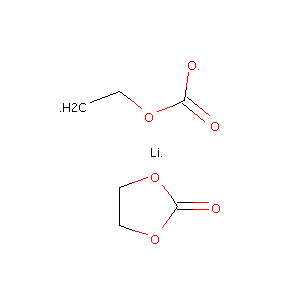

In [11]:
rdmol = Chem.MolFromSmiles("[Li].C1(=O)OCCO1.C(=O)([O])OC[CH2]")
Draw.MolToFile(rdmol, )

In [20]:
m = pybel.readstring("smi", "[Li].[CH2]COC([O])=O.O=C1OCCO1")
m.localopt()
# m.write("smi")
m.draw(show=False, filename="plz.png", usecoords=False)

In [70]:

G = nx.DiGraph()

for i, frame in enumerate(frames):
    if smiles[frame] not in G.nodes:
        if not G.nodes:
            G.add_node(smiles[frame], rank=0, image=unique_smiles[smiles[frame]]+'.png', label="")
        else:
            if (smiles[frames[i-1]], smiles[frame]) in G.out_edges:
                G.edges[smiles[frames[i-1]], smiles[frame]]['penwidth'] += 1
            else:
                G.add_node(smiles[frame], image=unique_smiles[smiles[frame]]+'.png', label="")
                G.add_edge(smiles[frames[i-1]], smiles[frame], penwidth=1.0)
    elif smiles[frames[i-1]] == smiles[frame]:
        pass
    else:
        if (smiles[frames[i-1]], smiles[frame]) in G.out_edges:
            G.edges[smiles[frames[i-1]], smiles[frame]]['penwidth'] += 1
        else:
            G.add_edge(smiles[frames[i-1]], smiles[frame], penwidth=1.0)
        

In [12]:
G2 = nx.convert_node_labels_to_integers(G)
nx.draw_spring(G2, with_labels=True)

In [13]:
G2.nodes(data=True)

NodeDataView({0: {'rank': 0, 'image': 'one.png', 'label': ''}, 1: {'image': 'two.png', 'label': ''}, 2: {'image': 'three.png', 'label': ''}, 3: {'image': 'four.png', 'label': ''}, 4: {'image': 'five.png', 'label': ''}, 5: {'image': 'six.png', 'label': ''}, 6: {'image': 'seven.png', 'label': ''}})

In [11]:
A = to_agraph(G)
print(A)

strict digraph {
	node [label="\N"];
	"[Li].C1(=O)OCCO1.C(=O)([O])OC[CH2]"	 [image="one.png",
		label="",
		rank=0];
	"[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O"	 [image="two.png",
		label=""];
	"[Li].C1(=O)OCCO1.C(=O)([O])OC[CH2]" -> "[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O"	 [penwidth=3.0];
	"[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O" -> "[Li].C1(=O)OCCO1.C(=O)([O])OC[CH2]"	 [penwidth=2.0];
	"[Li]OC1(OCCO1)OC[CH2].C(=O)=O"	 [image="three.png",
		label=""];
	"[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O" -> "[Li]OC1(OCCO1)OC[CH2].C(=O)=O"	 [penwidth=1.0];
	"[Li]OC(=O)OC[CH2].C1(=O)OCCO1"	 [image="four.png",
		label=""];
	"[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O" -> "[Li]OC(=O)OC[CH2].C1(=O)OCCO1"	 [penwidth=3.0];
	"[Li]OC1(OCCO1)OC[CH2].C(=O)=O" -> "[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O"	 [penwidth=2.0];
	"[Li].C1([O])(OCCO1)OC[CH2].C(=O)=O"	 [image="six.png",
		label=""];
	"[Li]OC1(OCCO1)OC[CH2].C(=O)=O" -> "[Li].C1([O])(OCCO1)OC[CH2].C(=O)=O"	 [penwidth=1.0];
	"[Li]OC(=O)OC[CH2].C1(=O)OCCO1" -> "[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O"	 [penwid

In [18]:
A.layout('dot')
A.draw('net.png', format="png:cairo:cairo")

OSError: Format: "png:cairo:cairo" not recognized. Use one of: png:quartz:quartz


In [147]:
write_dot(G, 'willitwork.dot')

In [148]:
os.system("dot -Tpng willitwork.dot -o itworked.png")

0

In [11]:
P = to_pydot(G)

In [12]:
P.write('plzwork.png', prog='dot', format='png')

True

In [31]:
PP = pydot.Dot(graph_type='graph')

node_a = pydot.Node("Node A", image="one.png")

PP.add_node(node_a)

In [88]:
nodes = list(G.nodes)
args = []
for i in G.nodes(data=True):
    args.append(i[1])
graphinfo = dict(zip(nodes, args))
graphinfo

{'[Li].C1(=O)OCCO1.C(=O)([O])OC[CH2]': {'image': 'one.png',
  'label': '',
  'rank': 0},
 '[Li].C1([O])(OCCO1)OC[CH2].C(=O)=O': {'image': 'six.png', 'label': ''},
 '[Li]OC(=O)OC[CH2].C1(=O)OCCO1': {'image': 'four.png', 'label': ''},
 '[Li]OC1(OCCO1)OC[CH2].C(=O)=O': {'image': 'three.png', 'label': ''},
 '[Li]OCCOC(=O)OC[CH2].C(=O)=O': {'image': 'seven.png', 'label': ''},
 '[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O': {'image': 'two.png', 'label': ''},
 '[Li]OC[CH2].C1(=O)OCCO1.[C](=O)[O]': {'image': 'five.png', 'label': ''}}

In [139]:
dot = Digraph(format='png')

In [142]:
for n in G.nodes:
    dot.node(n, label='', image=unique_smiles[n]+'.png')
dot.edges(G.edges)

In [143]:
unique_smiles

{'[Li].C1(=O)OCCO1.C(=O)([O])OC[CH2]': 'one',
 '[Li].C1([O])(OCCO1)OC[CH2].C(=O)=O': 'six',
 '[Li]OC(=O)OC[CH2].C1(=O)OCCO1': 'four',
 '[Li]OC1(OCCO1)OC[CH2].C(=O)=O': 'three',
 '[Li]OCCOC(=O)OC[CH2].C(=O)=O': 'seven',
 '[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O': 'two',
 '[Li]OC[CH2].C1(=O)OCCO1.[C](=O)[O]': 'five'}

In [144]:
print(dot.source)

digraph {
	"[Li].C1(=O)OCCO1.C(=O)([O])OC[CH2]" [label="" image="one.png"]
	"[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O" [label="" image="two.png"]
	"[Li]OC1(OCCO1)OC[CH2].C(=O)=O" [label="" image="three.png"]
	"[Li]OC(=O)OC[CH2].C1(=O)OCCO1" [label="" image="four.png"]
	"[Li]OC[CH2].C1(=O)OCCO1.[C](=O)[O]" [label="" image="five.png"]
	"[Li].C1([O])(OCCO1)OC[CH2].C(=O)=O" [label="" image="six.png"]
	"[Li]OCCOC(=O)OC[CH2].C(=O)=O" [label="" image="seven.png"]
	"[Li].C1(=O)OCCO1.C(=O)([O])OC[CH2]" -> "[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O"
	"[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O" -> "[Li]OC1(OCCO1)OC[CH2].C(=O)=O"
	"[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O" -> "[Li]OC(=O)OC[CH2].C1(=O)OCCO1"
	"[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O" -> "[Li].C1(=O)OCCO1.C(=O)([O])OC[CH2]"
	"[Li]OC1(OCCO1)OC[CH2].C(=O)=O" -> "[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O"
	"[Li]OC1(OCCO1)OC[CH2].C(=O)=O" -> "[Li].C1([O])(OCCO1)OC[CH2].C(=O)=O"
	"[Li]OC(=O)OC[CH2].C1(=O)OCCO1" -> "[Li]OC[CH2].C1(=O)OCCO1.C(=O)=O"
	"[Li]OC(=O)OC[CH2].C1(=O)OCCO1" -> "[Li]OC[C

In [145]:
dot.render('maybe', view=True)

'maybe.png'

In [137]:
for e in G.edges(data=True):
    dot.edge(e[0], e[1], label='', penwidth=e[2]['penwidth'])
    print(e[2]['penwidth'])

TypeError: expected string or bytes-like object

In [138]:
dd = Digraph()
dd.edge(1, 2, penwidth=4)

AttributeError: 'int' object has no attribute 'partition'